#Author: Md Mintu Miah, PhD; Post Doctoral Researcher at PATH, UC Berkeley
#Project: Contract 65A0911: Complete Cities: Bicycle Network Connectivity Evaluation Methodology
#PI: Alex Skabardonis, PhD, Professor, UC Berkeley

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections.abc import Mapping
from distutils.version import LooseVersion
from pybna import Importer
import geopandas as gpd
import pybna

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pybna\conf.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point
import io

In [8]:
%%time
# Import Configuration file
i = pybna.Importer(config="config.yaml")
# Import Study Area boundary shape file
i.import_boundary('City of Sacramento_Boundary.shp', overwrite=True)
# Mention the State fips, for California it is 6
i.import_census_blocks(fips=6, overwrite=True)
i.import_census_jobs("received.neighborhood_census_block_jobs",state="CA", overwrite=True)

Connecting to database
Copying boundary to database
Loading boundary
Loading data from http://www2.census.gov/geo/tiger/TIGER2010BLKPOPHU/tabblock2010_06_pophu.zip
Filtering blocks to boundary
Filtering out water
Copying blocks to database
Loading data for state CA
No data for state CA for year 2020. Checking previous year.
Copying jobs to database
CPU times: total: 1min 34s
Wall time: 11min 54s


In [9]:
%%time
i.import_osm_network(overwrite=True)

Copying OSM ways to database
Copying OSM intersections to database
Processing OSM data in database
CPU times: total: 3min 17s
Wall time: 4min 15s


In [10]:
%%time
# stress
s = pybna.Stress(config='config.yaml')
s.segment_stress()
s.crossing_stress()

Connecting to database
Calculating stress on shared streets
Calculating stress on streets with bike lanes
Calculating stress on streets with cycle tracks
Calculating stress on paths
Calculating stress on shared streets
Calculating stress on streets with bike lanes
Calculating stress on streets with cycle tracks
Calculating stress on paths
  ....forward
  ....backward
CPU times: total: 406 ms
Wall time: 24.6 s


In [5]:
# Read the LTS shape file
lts0=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/neighborhood_ways.shp")
lts0 = lts0.rename(columns={'OSMID':'osmid'})
lts0=lts0.rename({'INTERSECTI':'u', 'INTERSE_01':'v'}, axis='columns')
lts0['length']=lts0.length
lts0.head()

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length
0,21113,"{981539920,981539918,981539919}",secondary,None,ft,40884,40569,NaN,NaN,None,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (139267.831 99099.111, 139232.287 9...",114.734569
1,38818,{442356976},secondary,None,ft,4488,4485,NaN,NaN,None,...,None,?,?,4.0,NaN,NaN,NaN,None,"LINESTRING (126547.244 116173.957, 126546.974 ...",13.322725
2,40960,"{617694798,617694801,1025104341,1025104342,102...",secondary,None,ft,9751,9739,NaN,NaN,lane,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (128014.726 124945.470, 128153.759 ...",452.265878
3,50808,{617563730},primary,None,ft,34105,34106,NaN,NaN,None,...,None,?,?,4.0,NaN,NaN,NaN,None,"LINESTRING (136289.175 107312.461, 136272.973 ...",16.202618
4,54239,"{1025089940,617500413,1025089941,1019984317}",secondary,None,ft,7292,8709,NaN,NaN,None,...,None,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (130553.758 122728.366, 130528.530 ...",272.883211


In [6]:
# import crsooing identification buffer
buffer=gpd.read_file('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/Sacramento_seg_cross_Buffer.shp')
buffer

,Shape_Leng,Shape_Area,geometry
0,3.363138e+06,1.546822e+08,"MULTIPOLYGON (((134126.435 99237.896, 134133.3..."


In [7]:
def stress(FT_INT_STR,TF_INT_STR):
    if FT_INT_STR>0:
        return FT_INT_STR
    else:
        return TF_INT_STR
    
def stress2(Stress1,FT_SEG_STR):
    if Stress1>0:
        return Stress1
    else:
        return FT_SEG_STR

In [8]:
crossing_seg=gpd.clip(lts0,buffer)
crossing_seg['Stress1']=crossing_seg.apply(lambda row:stress(row['FT_INT_STR'],row['TF_INT_STR']),axis=1)
crossing_seg['Stress']=crossing_seg.apply(lambda row:stress2(row['Stress1'],row['FT_SEG_STR']),axis=1)
crossing_seg=crossing_seg.drop(['Stress1'],axis=1)
crossing_seg.head(10)

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,Stress
34335,12889,{10506373},residential,None,None,39974,39976,NaN,NaN,None,...,?,?,1.0,1.0,1.0,1.0,None,"LINESTRING (135892.674 98539.106, 135881.245 9...",83.201740,1.0
21534,16403,{10513050},residential,None,None,39975,39974,NaN,NaN,None,...,?,?,1.0,1.0,1.0,NaN,None,"LINESTRING (135832.605 98549.109, 135871.027 9...",140.066239,1.0
31800,12888,{10504288},residential,None,None,39969,39976,NaN,NaN,None,...,?,?,1.0,1.0,1.0,1.0,None,"MULTILINESTRING ((135962.844 98720.173, 135970...",375.983993,1.0
24797,16402,{10506373},residential,None,None,39974,39966,NaN,NaN,None,...,?,?,1.0,1.0,1.0,1.0,None,"LINESTRING (135892.674 98539.106, 135897.367 9...",117.862758,1.0
14794,16401,{10506374},residential,None,None,39967,39966,NaN,NaN,None,...,?,?,1.0,1.0,1.0,NaN,None,"LINESTRING (135888.948 98680.397, 135866.746 9...",44.481868,1.0
36774,12892,{10504288},residential,None,None,39964,39968,NaN,NaN,None,...,?,?,1.0,1.0,1.0,1.0,None,"MULTILINESTRING ((135618.761 98719.952, 135679...",258.014919,1.0
39211,12890,{10504288},residential,None,None,39968,39969,NaN,NaN,None,...,?,?,1.0,1.0,1.0,1.0,None,"LINESTRING (135870.091 98764.368, 135877.775 9...",107.347273,1.0
34336,12893,{10509852},residential,None,None,40089,39968,NaN,NaN,None,...,?,?,1.0,1.0,1.0,1.0,None,"LINESTRING (135831.092 98851.628, 135849.193 9...",97.033472,1.0
34286,12097,{10515825},residential,None,None,40089,40088,NaN,NaN,None,...,?,?,1.0,1.0,1.0,1.0,None,"LINESTRING (135831.092 98851.628, 135842.990 9...",102.310891,1.0
22686,12098,{567742845},residential,None,None,40086,40088,NaN,NaN,None,...,?,?,1.0,1.0,1.0,NaN,None,"LINESTRING (135970.495 98903.332, 135967.127 9...",77.655433,1.0


In [9]:
seg = lts0.overlay(crossing_seg, how='difference')
seg['Stress']=seg['FT_SEG_STR']
seg.head()

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,Stress
0,21113,"{981539920,981539918,981539919}",secondary,None,ft,40884,40569,NaN,NaN,None,...,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (139267.831 99099.111, 139232.287 9...",114.734569,NaN
1,40960,"{617694798,617694801,1025104341,1025104342,102...",secondary,None,ft,9751,9739,NaN,NaN,lane,...,?,?,NaN,NaN,NaN,NaN,None,"MULTILINESTRING ((128014.726 124945.470, 12815...",452.265878,NaN
2,54239,"{1025089940,617500413,1025089941,1019984317}",secondary,None,ft,7292,8709,NaN,NaN,None,...,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (130528.530 122768.063, 130502.523 ...",272.883211,NaN
3,54241,"{1033721769,1033721770,1033721772}",secondary,None,ft,8908,8907,NaN,NaN,None,...,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (129758.682 124442.145, 129744.451 ...",75.755043,NaN
4,102786,"{1029988642,617500412}",secondary,None,ft,8650,8647,NaN,NaN,None,...,?,?,NaN,NaN,NaN,NaN,None,"LINESTRING (130006.342 123290.429, 129992.699 ...",388.316012,NaN


In [10]:
lts=pd.concat([crossing_seg,seg],axis=0)
lts=gpd.GeoDataFrame.explode(lts).reset_index()
lts.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\3177649857.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  lts=gpd.GeoDataFrame.explode(lts).reset_index()


,level_0,level_1,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry
0,34335,0,12889,{10506373},residential,None,None,39974,39976,NaN,...,?,?,1.0,1.0,1.0,1.0,None,83.201740,1.0,"LINESTRING (135892.674 98539.106, 135881.245 9..."
1,21534,0,16403,{10513050},residential,None,None,39975,39974,NaN,...,?,?,1.0,1.0,1.0,NaN,None,140.066239,1.0,"LINESTRING (135832.605 98549.109, 135871.027 9..."
2,31800,0,12888,{10504288},residential,None,None,39969,39976,NaN,...,?,?,1.0,1.0,1.0,1.0,None,375.983993,1.0,"LINESTRING (135962.844 98720.173, 135970.928 9..."
3,31800,1,12888,{10504288},residential,None,None,39969,39976,NaN,...,?,?,1.0,1.0,1.0,1.0,None,375.983993,1.0,"LINESTRING (135936.502 98459.795, 135875.640 9..."
4,24797,0,16402,{10506373},residential,None,None,39974,39966,NaN,...,?,?,1.0,1.0,1.0,1.0,None,117.862758,1.0,"LINESTRING (135892.674 98539.106, 135897.367 9..."


# Lets calculate the slope for each link

In [11]:
#https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
import rasterio
from rasterio.plot import show
from rasterio import plot as rioplot
import matplotlib.pyplot as plt

EPSG:4269


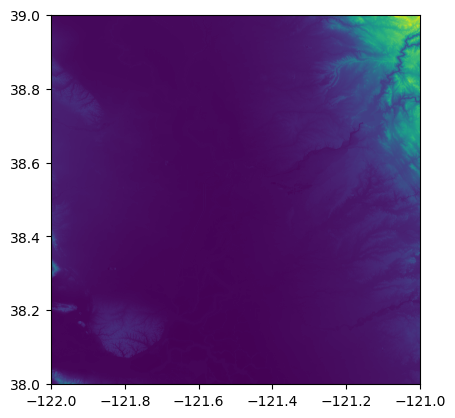

<AxesSubplot:>

In [12]:
# Open the raster image
barea_slope = rasterio.open('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/Slope/USGS_13_n39w122_20220206.tif')
print(barea_slope.crs)
rioplot.show(barea_slope)

In [13]:
# only band is elev value (in m)
band1 = barea_slope.read(1, masked=True)  # mask noData cells [shouldn't be necessary on land]
stats = {'min': band1.min(), 'mean': band1.mean(), 'max': band1.max()}
print(stats)

{'min': -7.3393726, 'mean': 42.889994523835824, 'max': 681.56647}


In [14]:
# Reproject the geometries by replacing the values with projected ones
lts_new = lts.to_crs(epsg=4326)
lts_new.head(10)

,level_0,level_1,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,...,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry
0,34335,0,12889,{10506373},residential,None,None,39974,39976,NaN,...,?,?,1.0,1.0,1.0,1.0,None,83.201740,1.0,"LINESTRING (-121.44361 38.41721, -121.44374 38..."
1,21534,0,16403,{10513050},residential,None,None,39975,39974,NaN,...,?,?,1.0,1.0,1.0,NaN,None,140.066239,1.0,"LINESTRING (-121.44429 38.41730, -121.44385 38..."
2,31800,0,12888,{10504288},residential,None,None,39969,39976,NaN,...,?,?,1.0,1.0,1.0,1.0,None,375.983993,1.0,"LINESTRING (-121.44278 38.41883, -121.44269 38..."
3,31800,1,12888,{10504288},residential,None,None,39969,39976,NaN,...,?,?,1.0,1.0,1.0,1.0,None,375.983993,1.0,"LINESTRING (-121.44311 38.41649, -121.44381 38..."
4,24797,0,16402,{10506373},residential,None,None,39974,39966,NaN,...,?,?,1.0,1.0,1.0,1.0,None,117.862758,1.0,"LINESTRING (-121.44361 38.41721, -121.44355 38..."
5,14794,0,16401,{10506374},residential,None,None,39967,39966,NaN,...,?,?,1.0,1.0,1.0,NaN,None,44.481868,1.0,"LINESTRING (-121.44363 38.41848, -121.44389 38..."
6,36774,0,12892,{10504288},residential,None,None,39964,39968,NaN,...,?,?,1.0,1.0,1.0,1.0,None,258.014919,1.0,"LINESTRING (-121.44672 38.41886, -121.44602 38..."
7,36774,1,12892,{10504288},residential,None,None,39964,39968,NaN,...,?,?,1.0,1.0,1.0,1.0,None,258.014919,1.0,"LINESTRING (-121.44450 38.41907, -121.44423 38..."
8,39211,0,12890,{10504288},residential,None,None,39968,39969,NaN,...,?,?,1.0,1.0,1.0,1.0,None,107.347273,1.0,"LINESTRING (-121.44384 38.41924, -121.44375 38..."
9,34336,0,12893,{10509852},residential,None,None,40089,39968,NaN,...,?,?,1.0,1.0,1.0,1.0,None,97.033472,1.0,"LINESTRING (-121.44427 38.42003, -121.44407 38..."


In [15]:
# get the slope for each link of the network
%time
lts_new
# First identify the starting and ending node of each link
lts_new['starting point'] = None
lts_new['ending point'] = None

for index, row in lts_new.iterrows():
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    lts_new.at[index,'starting point'] = Point(first_coord)
    lts_new.at[index,'ending point'] = Point(last_coord)
    lts_new

CPU times: total: 0 ns
Wall time: 0 ns


<AxesSubplot:>

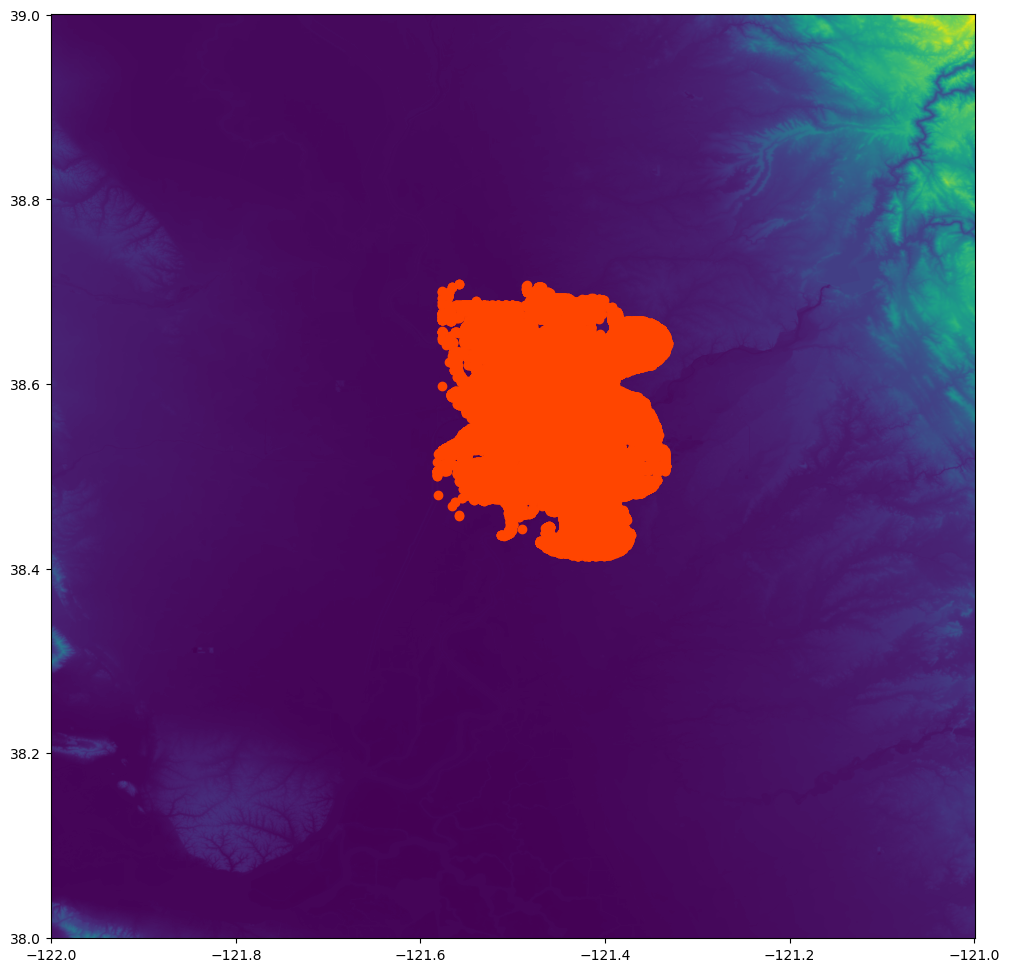

In [16]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(12,12))
lts_new.boundary.plot(ax=ax, color='orangered')
show(barea_slope, ax=ax)

In [17]:
# Calculate each link starting lat and long
sf1=lts_new.loc[:,["ROAD_ID","starting point"]]
sf1.columns=["ROAD_ID","geometry"]
sf1['start_lon'] = sf1.geometry.apply(lambda p: p.x)
sf1['start_lat'] = sf1.geometry.apply(lambda p: p.y)
sf2=sf1.loc[:,["ROAD_ID","geometry","start_lon","start_lat"]]
sf2.head(5)

,ROAD_ID,geometry,start_lon,start_lat
0,12889,POINT (-121.443605 38.41720900000001),-121.443605,38.417209
1,16403,POINT (-121.44429145958819 38.41730499879966),-121.444291,38.417305
2,12888,POINT (-121.442779 38.41883299999999),-121.442779,38.418833
3,12888,POINT (-121.4431131443039 38.41649031506737),-121.443113,38.416490
4,16402,POINT (-121.443605 38.41720900000001),-121.443605,38.417209


In [18]:
# Calculate each link starting elevation
sf2["starting_ele"]= None
#point in test['geometry']:
x = sf2["start_lon"]
y = sf2["start_lat"]
row, col = barea_slope.index(x,y)
sf2["starting_ele"]=barea_slope.read(1)[row,col]

In [19]:
%%time
# Calculate each link end point elevation
ef1=lts_new.loc[:,["ROAD_ID","ending point"]]
ef1.columns=["ROAD_ID","geometry"]
ef1['end_lon'] = ef1.geometry.apply(lambda p: p.x)
ef1['end_lat'] = ef1.geometry.apply(lambda p: p.y)
ef2=ef1.loc[:,["ROAD_ID","geometry","end_lon","end_lat"]]
ef2.head(5)

CPU times: total: 1.5 s
Wall time: 1.5 s


,ROAD_ID,geometry,end_lon,end_lat
0,12889,POINT (-121.44381 38.416491),-121.443810,38.416491
1,16403,POINT (-121.443605 38.41720900000001),-121.443605,38.417209
2,12888,POINT (-121.44253927349236 38.41831810991636),-121.442539,38.418318
3,12888,POINT (-121.44381 38.416491),-121.443810,38.416491
4,16402,POINT (-121.44388900000001 38.418136999999994),-121.443889,38.418137


In [20]:
%%time
# Calculate the each link end elevation
ef2["ending_ele"]= None
#point in test['geometry']:
x = ef2["end_lon"]
y = ef2["end_lat"]
row, col = barea_slope.index(x,y)
ef2["ending_ele"]=barea_slope.read(1)[row,col]

CPU times: total: 312 ms
Wall time: 301 ms


In [21]:
%%time
# Calculate the slope for each link
from functools import reduce
barea_all=[sf2,ef2,lts_new]

barea_all1= reduce(lambda  left,right: pd.merge(left,right,on=['ROAD_ID'],
                                            how='outer'), barea_all).fillna('0')
barea_all1["slope"]=abs((barea_all1['starting_ele']-barea_all1['ending_ele'])/barea_all1['length'])*100
barea_all1=barea_all1.drop_duplicates(subset=['ROAD_ID'], keep='first')
barea_all1.head()

CPU times: total: 2 s
Wall time: 2.01 s


,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope
0,12889,POINT (-121.443605 38.41720900000001),-121.443605,38.417209,6.958472,POINT (-121.44381 38.416491),-121.443810,38.416491,6.564182,34335,...,1.0,1.0,1.0,0,83.201740,1.0,"LINESTRING (-121.44361 38.41721, -121.44374 38...",POINT (-121.443605 38.41720900000001),POINT (-121.44381 38.416491),0.473896
1,16403,POINT (-121.44429145958819 38.41730499879966),-121.444291,38.417305,6.863154,POINT (-121.443605 38.41720900000001),-121.443605,38.417209,6.958472,21534,...,1.0,1.0,0,0,140.066239,1.0,"LINESTRING (-121.44429 38.41730, -121.44385 38...",POINT (-121.44429145958819 38.41730499879966),POINT (-121.443605 38.41720900000001),0.068052
9,12888,POINT (-121.442779 38.41883299999999),-121.442779,38.418833,7.010031,POINT (-121.44253927349236 38.41831810991636),-121.442539,38.418318,7.046728,31800,...,1.0,1.0,1.0,0,375.983993,1.0,"LINESTRING (-121.44278 38.41883, -121.44269 38...",POINT (-121.442779 38.41883299999999),POINT (-121.44253927349236 38.41831810991636),0.009760
36,16402,POINT (-121.443605 38.41720900000001),-121.443605,38.417209,6.958472,POINT (-121.44388900000001 38.418136999999994),-121.443889,38.418137,6.630188,24797,...,1.0,1.0,1.0,0,117.862758,1.0,"LINESTRING (-121.44361 38.41721, -121.44355 38...",POINT (-121.443605 38.41720900000001),POINT (-121.44388900000001 38.418136999999994),0.278530
37,16401,POINT (-121.44363 38.418482),-121.443630,38.418482,6.966001,POINT (-121.44388900000001 38.418136999999994),-121.443889,38.418137,6.630188,14794,...,1.0,1.0,0,0,44.481868,1.0,"LINESTRING (-121.44363 38.41848, -121.44389 38...",POINT (-121.44363 38.418482),POINT (-121.44388900000001 38.418136999999994),0.754943


<AxesSubplot:>

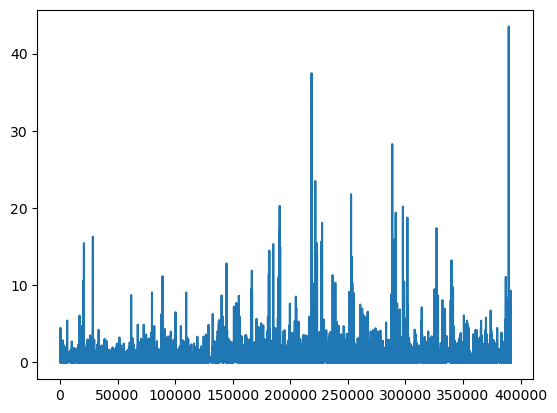

In [22]:
barea_all1.slope.plot()

In [67]:
# write a slope impedance function
def slope_correction(length,Stress,slope):
    if slope <=2:
        return length*(1+Stress)
    elif ((slope>2) and (slope<=4)):
        return length*(1+0.37+Stress)
    elif ((slope>4) and (slope<=6)):
        return length*(1+1.20+Stress)
    else:
        return length*(1+3.20+Stress)

In [68]:
#barea_all1['FT_SEG_STR'].astype(str).astype(int)
barea_all1['Stress']=pd.to_numeric(barea_all1['Stress']).astype(int)
barea_all1['Stress'].dtypes

dtype('int32')

In [69]:
barea_all1['impedance_of_link']=barea_all1.apply(lambda row: slope_correction(row['length'],row['Stress'],row['slope']),axis=1)
barea_all1.head(8)

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
0,12889,POINT (-121.443605 38.41720900000001),-121.443605,38.417209,6.958472,POINT (-121.44381 38.416491),-121.443810,38.416491,6.564182,34335,...,1.0,1.0,0,83.201740,1,"LINESTRING (-121.44361 38.41721, -121.44374 38...",POINT (-121.443605 38.41720900000001),POINT (-121.44381 38.416491),0.473896,166.403479
1,16403,POINT (-121.44429145958819 38.41730499879966),-121.444291,38.417305,6.863154,POINT (-121.443605 38.41720900000001),-121.443605,38.417209,6.958472,21534,...,1.0,0,0,140.066239,1,"LINESTRING (-121.44429 38.41730, -121.44385 38...",POINT (-121.44429145958819 38.41730499879966),POINT (-121.443605 38.41720900000001),0.068052,280.132478
9,12888,POINT (-121.442779 38.41883299999999),-121.442779,38.418833,7.010031,POINT (-121.44253927349236 38.41831810991636),-121.442539,38.418318,7.046728,31800,...,1.0,1.0,0,375.983993,1,"LINESTRING (-121.44278 38.41883, -121.44269 38...",POINT (-121.442779 38.41883299999999),POINT (-121.44253927349236 38.41831810991636),0.009760,751.967986
36,16402,POINT (-121.443605 38.41720900000001),-121.443605,38.417209,6.958472,POINT (-121.44388900000001 38.418136999999994),-121.443889,38.418137,6.630188,24797,...,1.0,1.0,0,117.862758,1,"LINESTRING (-121.44361 38.41721, -121.44355 38...",POINT (-121.443605 38.41720900000001),POINT (-121.44388900000001 38.418136999999994),0.278530,235.725516
37,16401,POINT (-121.44363 38.418482),-121.443630,38.418482,6.966001,POINT (-121.44388900000001 38.418136999999994),-121.443889,38.418137,6.630188,14794,...,1.0,0,0,44.481868,1,"LINESTRING (-121.44363 38.41848, -121.44389 38...",POINT (-121.44363 38.418482),POINT (-121.44388900000001 38.418136999999994),0.754943,88.963736
38,12892,POINT (-121.4467184 38.418864799999994),-121.446718,38.418865,6.705848,POINT (-121.44602155322723 38.418872232401206),-121.446022,38.418872,6.863061,36774,...,1.0,1.0,0,258.014919,1,"LINESTRING (-121.44672 38.41886, -121.44602 38...",POINT (-121.4467184 38.418864799999994),POINT (-121.44602155322723 38.418872232401206),0.060932,516.029838
65,12890,POINT (-121.4438354 38.419240200000004),-121.443835,38.419240,6.782914,POINT (-121.442779 38.41883299999999),-121.442779,38.418833,7.010031,39211,...,1.0,1.0,0,107.347273,1,"LINESTRING (-121.44384 38.41924, -121.44375 38...",POINT (-121.4438354 38.419240200000004),POINT (-121.442779 38.41883299999999),0.211572,214.694546
66,12893,POINT (-121.444271 38.42002999999999),-121.444271,38.420030,6.914694,POINT (-121.4438354 38.419240200000004),-121.443835,38.419240,6.782914,34336,...,1.0,1.0,0,97.033472,1,"LINESTRING (-121.44427 38.42003, -121.44407 38...",POINT (-121.444271 38.42002999999999),POINT (-121.4438354 38.419240200000004),0.135809,194.066944


### Lets Calculate the Connectivity

## Helper Function

In [70]:
def sf_connectivity_score (sf_motor_network,sf_bike_network):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
    # Calculate the total motor path
    sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()


    sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)
    sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
    # Calculate the total motor path
    sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

    #connectivity score
    sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
    connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [71]:
def graph_parameter(sf_motor_network,cul_de_sacs,convex_hull_area1,sf_area):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    # Calculate the number of Intersections
    crossroad_nodes = [node for node in sf_lts_motor_g1.nodes() if len(sf_lts_motor_g1.edges(node)) > 2]
    # Number of intersections where edge>2
    NI=get_number_of_elements(crossroad_nodes)
    # Calculate the parameters that we need
    edge_length_total1=sf_lts_motor_g.geometry.length.sum()
    street_segment_count1=sf_lts_motor_g1.number_of_edges()
    n1=sf_lts_motor_g1.number_of_nodes()
    sn=nx.number_connected_components(sf_lts_motor_g1)
#    cul_de_sacs=1102 # used cul-de-scas function from ArcGIS Pro
    
    Street_density=(edge_length_total1*0.000621371)/(convex_hull_area1*3.861e-7) # mile/square mile
    Intersection_density=(NI/convex_hull_area1*3.861e-7) # per mile square
    Street_density_by_land_area=(edge_length_total1*0.000621371)/(sf_area) # mile/square mile
    Intersection_density_by_land_area=(NI/sf_area) # per mile square
    CNR=(NI/(NI+cul_de_sacs))
    alpha=(street_segment_count1-n1+sn)/(2*n1-5)
    beta=street_segment_count1/n1
    gamma=street_segment_count1/(3*n1-2)
    eta=edge_length_total1/street_segment_count1
    GTP=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)
    Cyclomatic_Number=street_segment_count1-n1+1
    Aggregate_TP_score=alpha+beta+gamma+Cyclomatic_Number
    
    connectivity_score.append((NI,street_segment_count1,n1,sn,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,Cyclomatic_Number,Aggregate_TP_score))
    cols=['Number of Intersection','street_segment_count','Number of Node','Number of subnetwork','Street_density','Intersection_density','Street_density_by_land_area','Intersection_density_by_land_area','CNR','alpha','beta','gamma','eta','GTP','cyclomatic_Number','Aggregate_TP_score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result

In [72]:
def grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network):
    
    connectivity_score=[]

    for index, row in input_census_tract.iterrows():
        network_motor=gpd.clip(sf_motor_network,row['geometry'])
        sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
        sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
        # Calculate the total motor path
        sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()



        network_bike=gpd.clip(sf_bike_network,row['geometry'])
        sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
        sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
        # Calculate the total motor path
        sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

        #connectivity score
        sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
        connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [73]:
def count_census_block(Connectivity_score):
    if Connectivity_score>=1:
        return 'excellently connected'
    elif (Connectivity_score>=0.90 and Connectivity_score<1.0):
        return 'very well connected  '
    elif (Connectivity_score>=0.60 and Connectivity_score<0.90):
        return 'well connected'
    elif (Connectivity_score>=0.30 and Connectivity_score<0.60):
        return 'fairly connected'
    else:
        return 'poorly connected'

## Connectivity

In [74]:
# Bring US Census track
census_track=gpd.read_file('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/US_tract_2020.shp')
census_track1=census_track.to_crs(epsg=7131)
census_track1.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0100010020100,01,001,020100,01001020100,201,Census Tract 201,G5020,S,9825304.0,28435.0,+32.4819731,-086.4915648,16217.763443,9.853735e+06,"POLYGON ((3516926.098 77059.002, 3516963.104 7..."
1,G0100010020200,01,001,020200,01001020200,202,Census Tract 202,G5020,S,3320818.0,5669.0,+32.4757580,-086.4724678,9824.372415,3.326483e+06,"POLYGON ((3519482.809 73938.168, 3519490.446 7..."
2,G0100010020300,01,001,020300,01001020300,203,Census Tract 203,G5020,S,5349271.0,9054.0,+32.4740243,-086.4597033,10519.641206,5.358327e+06,"POLYGON ((3521117.478 74718.075, 3521099.105 7..."
3,G0100010020400,01,001,020400,01001020400,204,Census Tract 204,G5020,S,6384282.0,8408.0,+32.4710304,-086.4448353,12521.196228,6.392683e+06,"POLYGON ((3521674.809 77662.170, 3521681.008 7..."
4,G0100010020501,01,001,020501,01001020501,205.01,Census Tract 205.01,G5020,S,6203654.0,0.0,+32.4478607,-086.4225578,11422.446991,6.203654e+06,"POLYGON ((3525078.936 76191.813, 3525244.092 7..."


In [75]:
# read the Davis boundary shape file
study_bd=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/City of Sacramento_Boundary.shp")
study_bd

,OBJECTID,DISTRICT,CITY_NAME,ID,SHAPE_Leng,SHAPE_Area,geometry
0,8,CITY OF SACRAMENTO,SACRAMENTO,6,507620.447535,2.805403e+09,"POLYGON ((6697014.000 2011810.875, 6697823.000..."


<AxesSubplot:>

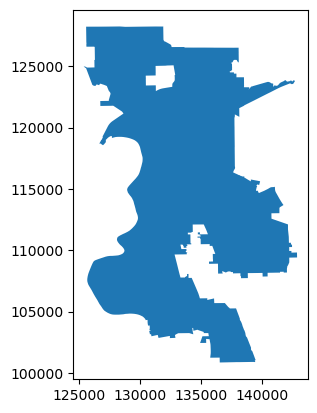

In [76]:
sf_bd_proj = study_bd.to_crs(epsg=7131)
sf_bd_proj.plot()

In [77]:
census_track2=gpd.clip(census_track1,sf_bd_proj)
census_track2.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
10029,G0600670009900,06,067,009900,06067009900,99,Census Tract 99,G5020,S,253729261.0,13027176.0,+38.2710059,-121.5387474,108022.727260,2.667565e+08,"POLYGON ((130651.623 104034.644, 130883.085 10..."
10013,G0600670009639,06,067,009639,06067009639,96.39,Census Tract 96.39,G5020,S,2849240.0,0.0,+38.4298959,-121.4080981,6670.261048,2.849242e+06,"POLYGON ((138916.872 100884.311, 139038.727 10..."
10003,G0600670009614,06,067,009614,06067009614,96.14,Census Tract 96.14,G5020,S,2252500.0,0.0,+38.4372640,-121.4319342,7842.083575,2.252500e+06,"MULTIPOLYGON (((137562.222 101121.474, 137593...."
10006,G0600670009618,06,067,009618,06067009618,96.18,Census Tract 96.18,G5020,S,15198729.0,219134.0,+38.4423863,-121.4660270,18407.208305,1.541786e+07,"MULTIPOLYGON (((135576.846 103535.126, 135580...."
13249,G0601130010401,06,113,010401,06113010401,104.01,Census Tract 104.01,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"MULTIPOLYGON (((126751.663 105550.545, 126764...."


In [78]:
census_track2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/Sacramento_City_cnesus_Tract.shp")

In [79]:
sf_bd_proj['area']=sf_bd_proj['geometry'].area*3.861e-7 # mile square
sf_bd_proj

,OBJECTID,DISTRICT,CITY_NAME,ID,SHAPE_Leng,SHAPE_Area,geometry,area
0,8,CITY OF SACRAMENTO,SACRAMENTO,6,507620.447535,2.805403e+09,"POLYGON ((128411.870 128244.489, 128658.574 12...",100.658289


In [80]:
sf_area=sf_bd_proj[['area']].sum()
sf_area

area    100.658289
dtype: float64

In [81]:
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
0,12889,POINT (-121.443605 38.41720900000001),-121.443605,38.417209,6.958472,POINT (-121.44381 38.416491),-121.443810,38.416491,6.564182,34335,...,1.0,1.0,0,83.201740,1,"LINESTRING (135892.674 98539.106, 135881.245 9...",POINT (-121.443605 38.41720900000001),POINT (-121.44381 38.416491),0.473896,166.403479
1,16403,POINT (-121.44429145958819 38.41730499879966),-121.444291,38.417305,6.863154,POINT (-121.443605 38.41720900000001),-121.443605,38.417209,6.958472,21534,...,1.0,0,0,140.066239,1,"LINESTRING (135832.605 98549.109, 135871.027 9...",POINT (-121.44429145958819 38.41730499879966),POINT (-121.443605 38.41720900000001),0.068052,280.132478
9,12888,POINT (-121.442779 38.41883299999999),-121.442779,38.418833,7.010031,POINT (-121.44253927349236 38.41831810991636),-121.442539,38.418318,7.046728,31800,...,1.0,1.0,0,375.983993,1,"LINESTRING (135962.844 98720.173, 135970.928 9...",POINT (-121.442779 38.41883299999999),POINT (-121.44253927349236 38.41831810991636),0.009760,751.967986
36,16402,POINT (-121.443605 38.41720900000001),-121.443605,38.417209,6.958472,POINT (-121.44388900000001 38.418136999999994),-121.443889,38.418137,6.630188,24797,...,1.0,1.0,0,117.862758,1,"LINESTRING (135892.674 98539.106, 135897.367 9...",POINT (-121.443605 38.41720900000001),POINT (-121.44388900000001 38.418136999999994),0.278530,235.725516
37,16401,POINT (-121.44363 38.418482),-121.443630,38.418482,6.966001,POINT (-121.44388900000001 38.418136999999994),-121.443889,38.418137,6.630188,14794,...,1.0,0,0,44.481868,1,"LINESTRING (135888.948 98680.397, 135866.746 9...",POINT (-121.44363 38.418482),POINT (-121.44388900000001 38.418136999999994),0.754943,88.963736


In [82]:
# Now lets crop the alameda area of lTS network
sf_lts=gpd.clip(barea_all3,sf_bd_proj)
sf_lts.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,level_0,...,TF_SEG_STR,TF_INT_STR,XWALK,length,Stress,geometry,starting point,ending point,slope,impedance_of_link
78377,15845,POINT (-121.41320490000001 38.4381143),-121.413205,38.438114,8.577115,POINT (-121.41320000000002 38.4380024),-121.413200,38.438002,8.479541,10950,...,1.0,3.0,0,12.430141,4,"LINESTRING (138521.604 100889.213, 138522.107 ...",POINT (-121.41320490000001 38.4381143),POINT (-121.41320000000002 38.4380024),0.784981,62.150703
78015,68309,POINT (-121.4114012 38.4381186),-121.411401,38.438119,9.148976,POINT (-121.41209846554253 38.43811694101974),-121.412098,38.438117,8.920944,47689,...,0,1.0,0,157.494007,1,"LINESTRING (138679.082 100891.464, 138618.205 ...",POINT (-121.4114012 38.4381186),POINT (-121.41209846554253 38.43811694101974),0.144788,314.988014
78042,68307,POINT (-121.41050619999999 38.43813790000001),-121.410506,38.438138,8.504109,POINT (-121.4114012 38.4381186),-121.411401,38.438119,9.148976,47687,...,0,1.0,0,78.177897,1,"LINESTRING (138757.202 100894.487, 138679.082 ...",POINT (-121.41050619999999 38.43813790000001),POINT (-121.4114012 38.4381186),0.824871,156.355793
78043,48461,POINT (-121.4114012 38.4381186),-121.411401,38.438119,9.148976,POINT (-121.41139940000001 38.438673400000006),-121.411399,38.438673,9.374659,26026,...,1.0,3.0,0,61.592322,1,"LINESTRING (138679.082 100891.464, 138678.545 ...",POINT (-121.4114012 38.4381186),POINT (-121.41139940000001 38.438673400000006),0.366413,123.184644
80078,88294,POINT (-121.40349760000001 38.4379753),-121.403498,38.437975,11.485599,POINT (-121.4041869499401 38.438057523384465),-121.404187,38.438058,9.254628,47907,...,0,1.0,0,126.872203,1,"LINESTRING (139369.336 100883.363, 139309.044 ...",POINT (-121.40349760000001 38.4379753),POINT (-121.4041869499401 38.438057523384465),1.758439,253.744406


In [83]:
# Convert the LTS shape file to graph to run the 
sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)
sf_lts_g1 =momepy.gdf_to_nx(sf_lts_g, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\1286791951.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)


In [84]:
#  f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
#  sf_lts.plot(color='#e32e00', ax=ax[0])
#  for i, facet in enumerate(ax):
#      facet.set_title(("Streets", "Primal graph", "Overlay")[i])
#      facet.axis("off")
#  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[1], node_size=0.01)
#  sf_lts.plot(color='#e32e00', ax=ax[2], zorder=-1)
#  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[2], node_size=0.01)

<AxesSubplot:>

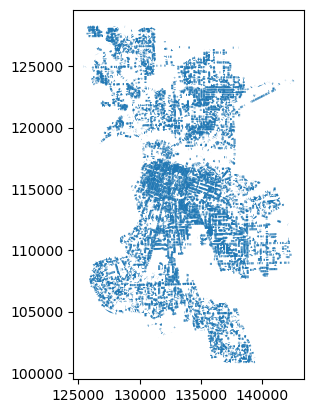

In [85]:
sf_lts['geometry'].convex_hull.plot()

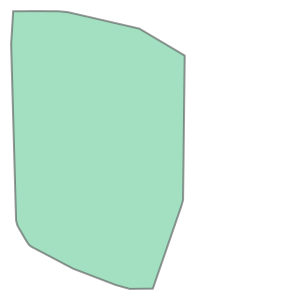

In [86]:
# Get the Convex Hull of the network
convex_hull_area = sf_lts.unary_union.convex_hull
# Show output
convex_hull_area

<AxesSubplot:>

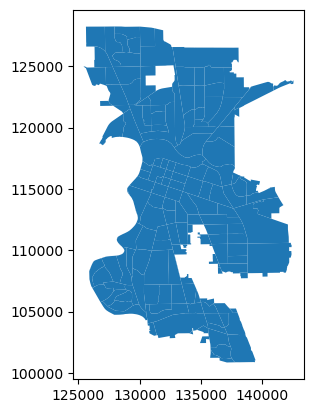

In [87]:
census_track3_sf=gpd.clip(census_track2,convex_hull_area)
census_track3_sf.plot()

In [88]:
convex_hull_area1=convex_hull_area.area
convex_hull_area1

399369602.6985693

In [89]:
# Calculate the number of Intersections
crossroad_nodes = [node for node in sf_lts_g1.nodes() if len(sf_lts_g1.edges(node)) > 2]

In [90]:
def get_number_of_elements(list):
    count = 0
    for element in list:
        count += 1
    return count

#print("Number of elements in the list: ", get_number_of_elements(list_c))

In [91]:
# Number of intersections where edge>2
NI=get_number_of_elements(crossroad_nodes)
NI

8786

# Bicycle Vs Motor Network Connectivity

<AxesSubplot:>

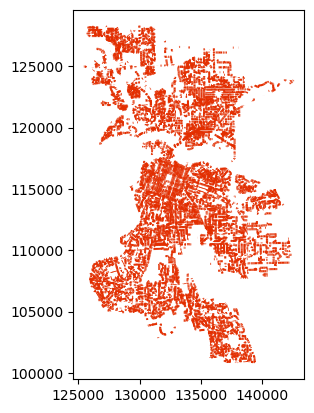

In [92]:
# Get the motorway network and bike network based on functional class of the roads
#sf_motor_network=sf_lts[sf_lts['BIKE_LANE_'].isna()]
sf_motor_network=sf_lts.loc[sf_lts['FT_BIKE_IN']=='0']
# Plot the motor Network
sf_motor_network.plot(color='#e32e00')

<AxesSubplot:>

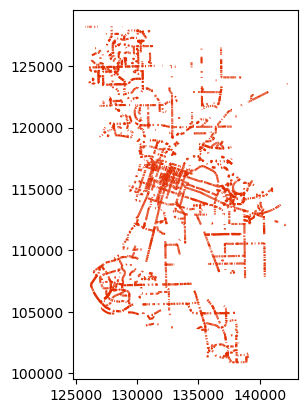

In [93]:
# Plot the Bike Network
sf_bike_network=sf_lts.loc[sf_lts['FT_BIKE_IN']!='0']
sf_bike_network.plot(color='#e32e00')

In [94]:
input_census_tract=census_track2.reset_index()
input_census_tract.shape

(172, 17)

In [95]:
## Calculate the connectivity score for bike vs motor network condition
sf_connectivity_score (sf_motor_network,sf_bike_network)

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,1.945107e+09,1.393415e+08,0.071637


In [96]:
SF_CS=grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network)
cs_census_track=pd.merge(SF_CS, input_census_tract, left_index=True, right_index=True)
cs_census_track.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:31: RuntimeWarning: invalid value encountered in double_scalars
  sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarnin

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:31: RuntimeWarning: invalid value encountered in double_scalars
  sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:31: RuntimeWarning: invalid value encountered in double_scalars
  sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score,index,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,70165.937246,6817.950132,0.097169,10029,G0600670009900,06,067,009900,06067009900,99,Census Tract 99,G5020,S,253729261.0,13027176.0,+38.2710059,-121.5387474,108022.727260,2.667565e+08,"POLYGON ((130651.623 104034.644, 130883.085 10..."
1,151.228328,151.051181,0.998829,10013,G0600670009639,06,067,009639,06067009639,96.39,Census Tract 96.39,G5020,S,2849240.0,0.0,+38.4298959,-121.4080981,6670.261048,2.849242e+06,"POLYGON ((138916.872 100884.311, 139038.727 10..."
2,372676.856492,7688.260262,0.020630,10003,G0600670009614,06,067,009614,06067009614,96.14,Census Tract 96.14,G5020,S,2252500.0,0.0,+38.4372640,-121.4319342,7842.083575,2.252500e+06,"MULTIPOLYGON (((137562.222 101121.474, 137593...."
3,12329.941386,28997.127814,2.351765,10006,G0600670009618,06,067,009618,06067009618,96.18,Census Tract 96.18,G5020,S,15198729.0,219134.0,+38.4423863,-121.4660270,18407.208305,1.541786e+07,"MULTIPOLYGON (((135576.846 103535.126, 135580...."
4,0.000000,0.000000,NaN,13249,G0601130010401,06,113,010401,06113010401,104.01,Census Tract 104.01,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"MULTIPOLYGON (((126751.663 105550.545, 126764...."


In [97]:
cs_census_track['Connectivity score'].median()

0.08972305098038996

In [98]:
cs_census_track['Connectivity score'].mean()

inf

In [99]:
crs = {'init': 'epsg:7131'}
gdf = gpd.GeoDataFrame(cs_census_track, crs=crs, geometry = 'geometry')
gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/Sacramento_City_B_vs_Motor_seg_cross_CS.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\184215642.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/Sacramento_City_B_vs_Motor_seg_cross_CS.shp")


In [100]:
gdf ['cs_ranking']=gdf .apply(lambda row:count_census_block(row['Connectivity score']),axis=1 )
gdf.head()

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score,index,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,...,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,cs_ranking
0,70165.937246,6817.950132,0.097169,10029,G0600670009900,06,067,009900,06067009900,99,...,G5020,S,253729261.0,13027176.0,+38.2710059,-121.5387474,108022.727260,2.667565e+08,"POLYGON ((130651.623 104034.644, 130883.085 10...",poorly connected
1,151.228328,151.051181,0.998829,10013,G0600670009639,06,067,009639,06067009639,96.39,...,G5020,S,2849240.0,0.0,+38.4298959,-121.4080981,6670.261048,2.849242e+06,"POLYGON ((138916.872 100884.311, 139038.727 10...",very well connected
2,372676.856492,7688.260262,0.020630,10003,G0600670009614,06,067,009614,06067009614,96.14,...,G5020,S,2252500.0,0.0,+38.4372640,-121.4319342,7842.083575,2.252500e+06,"MULTIPOLYGON (((137562.222 101121.474, 137593....",poorly connected
3,12329.941386,28997.127814,2.351765,10006,G0600670009618,06,067,009618,06067009618,96.18,...,G5020,S,15198729.0,219134.0,+38.4423863,-121.4660270,18407.208305,1.541786e+07,"MULTIPOLYGON (((135576.846 103535.126, 135580....",excellently connected
4,0.000000,0.000000,NaN,13249,G0601130010401,06,113,010401,06113010401,104.01,...,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"MULTIPOLYGON (((126751.663 105550.545, 126764....",poorly connected


In [101]:
# Now count the census tract for Bay area by cs ranking
gdf.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected     19
fairly connected          11
poorly connected         132
very well connected        4
well connected             6
Name: GISJOIN, dtype: int64

# Consider high Stress Vs Low Stress connectivity: using Formula "Shortest Path(LTS1+LTS2)/Shortest Path in motor network

In [102]:
# Split the network as low VS high stress network to get the connectivity by stress level
sf_motor_network_op2=sf_motor_network
sf_bike_network_op2=sf_lts.loc[sf_lts['Stress']<3]

In [103]:
# low Vs High stress connectivity score
## Calculate the connectivity score for bike vs motor network condition
low_high_stress_CS=sf_connectivity_score (sf_motor_network_op2,sf_bike_network_op2)
low_high_stress_CS

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,1.945107e+09,1.925424e+09,0.98988


In [104]:
# Calculate the census level stress for high vs low stress network
SF_CS_hl=grid_connectivity_score (input_census_tract,sf_bike_network_op2,sf_motor_network_op2)
SF_CS_hl.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,10090.279628,70165.937246,6.953815
1,0.000000,151.228328,inf
2,386567.915235,372676.856492,0.964066
3,34946.989930,12329.941386,0.352818
4,0.000000,0.000000,NaN


In [105]:
SF_CS_hl['Connectivity score'].median()

0.9230368497794963

In [106]:
cs_census_track_hl=pd.merge(SF_CS_hl, input_census_tract, left_index=True, right_index=True)
crs = {'init': 'epsg:7131'}
gdf_hl = gpd.GeoDataFrame(cs_census_track_hl, crs=crs, geometry = 'geometry')
gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/Sacramento_City_Census_track_level_seg_corss_CS_hl.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_15168\2633944189.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Sacramento Natwork Connectivity/Sacramento_City_Census_track_level_seg_corss_CS_hl.shp")


In [107]:
gdf_hl['cs_ranking']=gdf_hl.apply(lambda row:count_census_block(row['Connectivity score']),axis=1 )
gdf_hl.head()

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score,index,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,...,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,cs_ranking
0,10090.279628,70165.937246,6.953815,10029,G0600670009900,06,067,009900,06067009900,99,...,G5020,S,253729261.0,13027176.0,+38.2710059,-121.5387474,108022.727260,2.667565e+08,"POLYGON ((130651.623 104034.644, 130883.085 10...",excellently connected
1,0.000000,151.228328,inf,10013,G0600670009639,06,067,009639,06067009639,96.39,...,G5020,S,2849240.0,0.0,+38.4298959,-121.4080981,6670.261048,2.849242e+06,"POLYGON ((138916.872 100884.311, 139038.727 10...",excellently connected
2,386567.915235,372676.856492,0.964066,10003,G0600670009614,06,067,009614,06067009614,96.14,...,G5020,S,2252500.0,0.0,+38.4372640,-121.4319342,7842.083575,2.252500e+06,"MULTIPOLYGON (((137562.222 101121.474, 137593....",very well connected
3,34946.989930,12329.941386,0.352818,10006,G0600670009618,06,067,009618,06067009618,96.18,...,G5020,S,15198729.0,219134.0,+38.4423863,-121.4660270,18407.208305,1.541786e+07,"MULTIPOLYGON (((135576.846 103535.126, 135580....",fairly connected
4,0.000000,0.000000,NaN,13249,G0601130010401,06,113,010401,06113010401,104.01,...,G5020,S,348856897.0,8188502.0,+38.4284581,-121.6491713,89877.146298,3.570455e+08,"MULTIPOLYGON (((126751.663 105550.545, 126764....",poorly connected


In [108]:
# Now count the census tract for Bay area by cs ranking
gdf_hl.groupby(['cs_ranking'])['cs_ranking'].count()

cs_ranking
excellently connected    65
fairly connected         21
poorly connected         26
very well connected      19
well connected           41
Name: cs_ranking, dtype: int64

# End of coding